<a href="https://colab.research.google.com/github/LidorAmitay/CV-Final-Project-PlantPathology2021/blob/main/CV_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO:

* Add training and validation graphs (loss and metric)
  * Create 2 dataframes : train and validation
  * for each df, the columns should be : loss, metric
  * Plot relevant graphs using plotly(?)
* Add augmentations presentation (display relevant augs and write few words about them)
  * for each augmentation : display img before and after
  * short description and why it fits
* 



## Imports & Installations

In [1]:
import os
import pandas as pd
import math
import cv2 as cv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
# import seaborn as sn
%matplotlib inline

In [2]:
import gc 
gc.collect() 
torch.cuda.empty_cache()

In [3]:
!pip install torchmetrics

     |████████████████████████████████| 235kB 4.3MB/s 


In [4]:
import torchmetrics

In [5]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-3djh4e6g


In [6]:
! pip install albumentations==0.4.6


     |████████████████████████████████| 122kB 4.3MB/s 
     |████████████████████████████████| 952kB 7.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=87671d7cfbef2e37f7a45917dc440701dd05e9ad8c50a39aa62b1bc8d40b4fa4
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 1.0.2
    Uninstalling albumentations-1.0.2:
      Successfully uninstalled albumentations-1.0.2


## Downloading resized dataset

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp '/gdrive/MyDrive/Computer Vision/kaggle./kaggle.json' ~/.kaggle/ # Lidor
# !cp "/gdrive/MyDrive/CV_Final_Project/kaggle./kaggle.json" ~/.kaggle/ # Marko
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ankursingh12/resized-plant2021 -p Dataset

     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 4.2MB 27.2MB/s 
     |████████████████████████████████| 143kB 49.2MB/s 
     |████████████████████████████████| 112kB 54.5MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-hid1y9ea/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-hid1y9ea/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-h4fw1yxr/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
{"username":"lidoramitay","key":"d4143fc0ba31545e1627000bd04f8295"}Downloading resized-plant2021.zi

In [9]:
!unzip "/content/Dataset/resized-plant2021.zip"

Streaming output truncated to the last 5000 lines.
  inflating: img_sz_640/e00c97b2de4749ce.jpg  
  inflating: img_sz_640/e00df890cfe62736.jpg  
  inflating: img_sz_640/e00ed0bf43a87f25.jpg  
  inflating: img_sz_640/e00f759d65d52887.jpg  
  inflating: img_sz_640/e00f934d9e50ad5b.jpg  
  inflating: img_sz_640/e00fce341cb63da5.jpg  
  inflating: img_sz_640/e010c7c35ecf3d1c.jpg  
  inflating: img_sz_640/e01112939f783fec.jpg  
  inflating: img_sz_640/e01592da4d71b8be.jpg  
  inflating: img_sz_640/e0189acaf8cf80fd.jpg  
  inflating: img_sz_640/e0189e4999bdd0fa.jpg  
  inflating: img_sz_640/e01ae16d4a759cb5.jpg  
  inflating: img_sz_640/e01dc39ccb2b4ccb.jpg  
  inflating: img_sz_640/e01e42d90c66f3f3.jpg  
  inflating: img_sz_640/e01e870bec65f40f.jpg  
  inflating: img_sz_640/e01f17e0187fb80f.jpg  
  inflating: img_sz_640/e01f503cb752e6c5.jpg  
  inflating: img_sz_640/e024b69a784e9fc3.jpg  
  inflating: img_sz_640/e026b4c23c9fcfc4.jpg  
  inflating: img_sz_640/e027c790fc0a5edc.jpg  
  inflati

#=======================================================================

In [10]:
DEBUG = False

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
PATH_TO_IMAGES = '/content/img_sz_256/'

## Pre - processing

In [13]:
# train_df = pd.read_csv('/gdrive/MyDrive/CV_Final_Project/train.csv') # Marko
train_df = pd.read_csv('/gdrive/MyDrive/Computer Vision/Final_Project/train.csv') # Lidor

In [14]:
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [15]:
# Count of each decease
train_df['labels'].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [16]:
from collections import defaultdict

dct = defaultdict(list)
# For each label, getting the indexes of all of the leaf images that belong to that label
for i, label in enumerate(train_df.labels):
    for category in label.split():
        dct[category].append(i)
 
dct = {key: np.array(val) for key, val in dct.items()}
dct

{'complex': array([    1,     4,     8, ..., 18597, 18604, 18617]),
 'frog_eye_leaf_spot': array([    1,    14,    31, ..., 18612, 18619, 18630]),
 'healthy': array([    0,     5,     7, ..., 18626, 18627, 18631]),
 'powdery_mildew': array([   20,    39,    44, ..., 18532, 18617, 18618]),
 'rust': array([    6,    21,    26, ..., 18601, 18616, 18629]),
 'scab': array([    1,     2,     3, ..., 18625, 18628, 18630])}

### One-Hot encoding 

In [17]:
new_df = pd.DataFrame(np.zeros((train_df.shape[0], len(dct.keys())), dtype=np.int8), columns=dct.keys())

for key, val in dct.items():
    new_df.loc[val, key] = 1

new_df.head()

,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,1,0,0,0,0,0
1,0,1,1,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0


In [18]:
classes = ['healthy', 'scab',	'frog_eye_leaf_spot',	'complex',	'rust',	'powdery_mildew']
NUM_OF_CLASSES = len(classes)
NUM_OF_CLASSES

6

In [19]:
for index, label in enumerate(classes):
  print(f'index #{index}, class : {label}')

index #0, class : healthy
index #1, class : scab
index #2, class : frog_eye_leaf_spot
index #3, class : complex
index #4, class : rust
index #5, class : powdery_mildew


In [20]:
# Concatenate the original data frame to the one hot encoding labels
df_all = pd.concat([train_df, new_df], axis=1)
df_all.to_csv('better_train.csv', index = False)
df_all.head()

,image,labels,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,800113bb65efe69e.jpg,healthy,1,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,0,1,1,1,0,0
2,80070f7fb5e2ccaa.jpg,scab,0,1,0,0,0,0
3,80077517781fb94f.jpg,scab,0,1,0,0,0,0
4,800cbf0ff87721f8.jpg,complex,0,0,0,1,0,0


## Remove duplicates

In [21]:
# duplicates = pd.read_csv("/gdrive/MyDrive/CV_Final_Project/duplicates.csv",  names=('image1', 'image2')) #Marko
duplicates = pd.read_csv('/gdrive/MyDrive/Computer Vision/Final_Project/duplicates.csv',  names=('image1', 'image2'))
sorted_index = duplicates['image1'].sort_values().index
duplicates = duplicates.iloc[sorted_index].reset_index(drop=True)
duplicates.head()

,image1,image2
0,83e3d2369933c5d2.jpg,83e3d2329933c5f2.jpg
1,848d9f9e82d18e5e.jpg,949b6595a5b8ca3c.jpg
2,8dbeda49894d522e.jpg,afbe5641896d522a.jpg
3,8f5263c61a8cdbe2.jpg,c9d63696629107ed.jpg
4,90a5341f227ce5f9.jpg,f3dc17a2b20d48ec.jpg


In [22]:
for idx, images in duplicates.iterrows():
  # print(images['image1'])
  mask1 = train_df['image'] == images['image1']
  mask2 = train_df['image'] == images['image2']
  tmp = train_df[mask1].iloc[0, 2:].values | train_df[mask2].iloc[0, 2:].values
  train_df.loc[mask1, train_df.columns[2:]] = tmp
  train_df = train_df.drop(train_df[mask2].index)
assert (len(new_df) - len(duplicates)) == len(train_df)


In [23]:
# y = targets, X = images id's
y = df_all.iloc[:, 2:].values
X = df_all['image'] 

###Label Distribution 


In [24]:
source = df_all['labels'].value_counts()

In [25]:
fig = go.Figure(data=[go.Pie(labels=source.index,values=source.values)])
fig.update_layout(title='Label distribution')
fig.show()

In [26]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv.imread(os.path.join(path, image_id))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

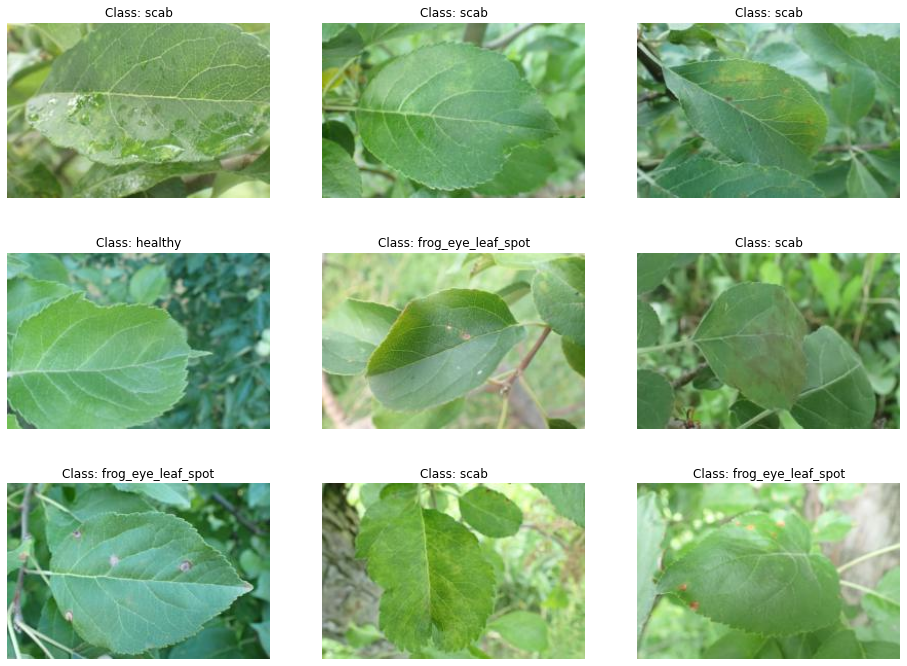

In [27]:
tmp_df = train_df.sample(9)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_batch(PATH_TO_IMAGES,image_ids,labels)

In [28]:
TRAIN_SIZE = 0.8 # Test size 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - TRAIN_SIZE, random_state=42)

In [29]:
X_train = X_train.reset_index().drop('index', axis = 1)
# y_train = y_train.reset_index().drop('index', axis = 1)

In [30]:
X_test = X_test.reset_index().drop('index', axis = 1)
# y_test = y_test.reset_index().drop('index', axis = 1)

##Augmentations
Now we will display the chosen augmentations.  
we wanted that the augs that we have chosen will not harm the images, and just add some variation. The main goal of augmentation is to add diversity and to avoid overfitting.


In [31]:
def display_imgs(images, titles, rows, cols):
  fig = plt.figure(figsize=(18,14))
  for i in range(rows * cols):
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.xticks([]), plt.yticks([])
    plt.title(titles[i])
  plt.show()

### Flip

In [32]:
img_id = X[np.random.randint(0, len(X))]
img = cv.imread(os.path.join(PATH_TO_IMAGES, img_id))

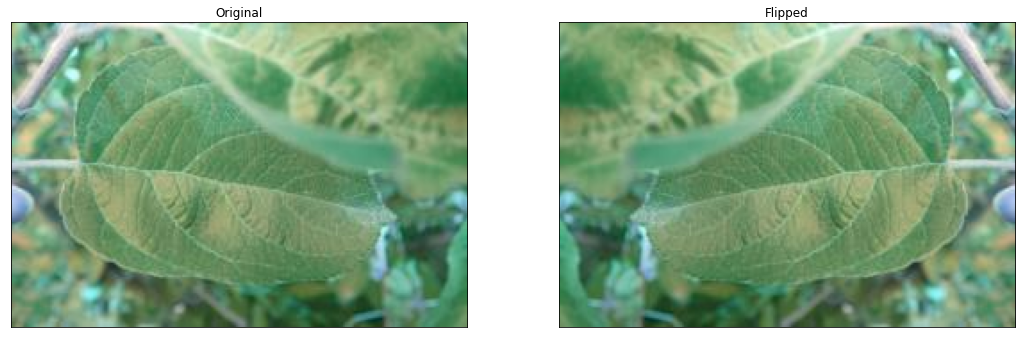

In [33]:
trans = A.Compose([A.Flip(always_apply=True),])
flipped_img = trans(image = img)['image']

display_imgs([img, flipped_img], ['Original', "Flipped"], 1, 2)

### Random Rotation
up to 90 degree

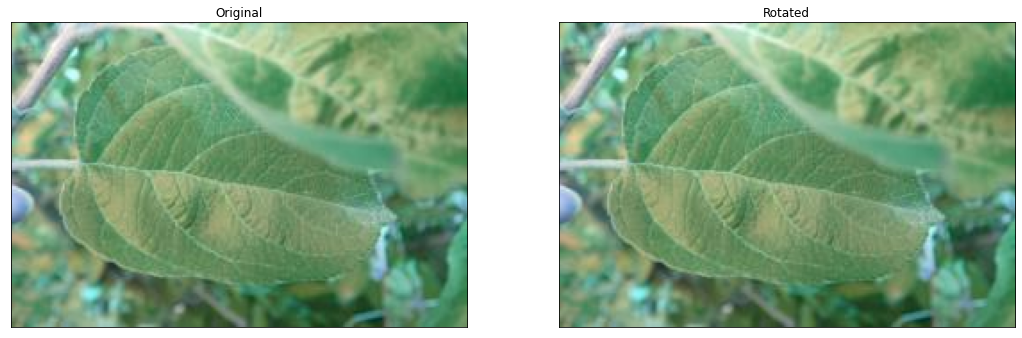

In [34]:
trans = A.Compose([A.RandomRotate90(always_apply=True),])
rotated_img = trans(image = img)['image']

display_imgs([img, rotated_img], ['Original', "Rotated"], 1, 2)

### RandomBrightnessContrast & RandomGamma

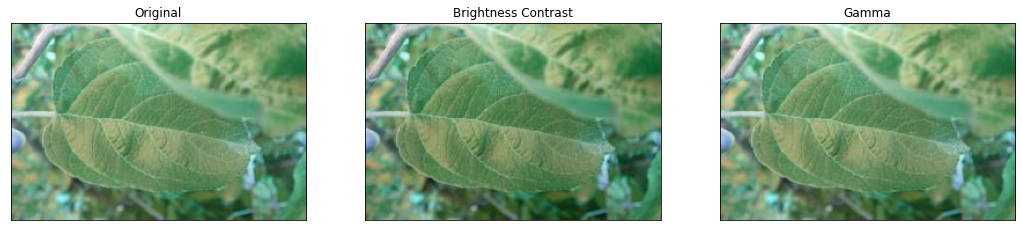

In [35]:
trans = A.Compose([A.RandomBrightnessContrast(always_apply=True),])
brighttened_img = trans(image = img)['image']

trans = A.Compose([A.RandomGamma(always_apply=True),])
gamma_img = trans(image = img)['image']

display_imgs([img, brighttened_img, gamma_img], ['Original', 'Brightness Contrast', 'Gamma'], 1, 3)

### Blur & Motion Blur

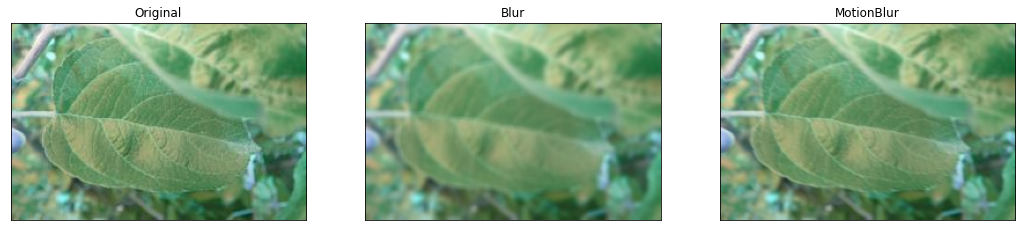

In [36]:
trans = A.Compose([A.Blur(always_apply=True),])
blurred_img = trans(image = img)['image']

trans = A.Compose([A.MotionBlur(always_apply=True),])
m_blurred_img = trans(image = img)['image']

display_imgs([img, blurred_img, m_blurred_img], ['Original', 'Blur', 'MotionBlur'], 1, 3)

In [37]:
from albumentations.pytorch import ToTensorV2

In [38]:
IMG_SIZE = 256

# Train Augmentations 
transform = A.Compose([
        A.Flip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.OneOf([
                A.RandomBrightnessContrast(p=0.5),
                A.RandomGamma(p=0.5),
            ], p=0.5),
        A.OneOf([
                A.Blur(p=0.1),
                # A.GaussianBlur(p=0.1),
                A.MotionBlur(p=0.1),
        ], p=0.1),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
])

# Test Augmentations
test_transform = A.Compose([
        A.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
])

In [39]:
class PlantPathologyDataset(Dataset):
  def __init__(self, PATH, X, y, transform = None):
    self.PATH = PATH
    self.X = X
    self.y = y
    self.transform = transform
  
  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, idx):
    img_path = self.PATH + self.X['image'][idx]
    img = cv.imread(img_path)
    img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
    label = self.y[idx]
    label = torch.tensor(label)
    if self.transform :
      img = self.transform(image = img)['image']
    sample = {'image':img, 'label':label}
    return sample

In [40]:
if DEBUG:
  X_train, y_train =  X_train[:200], y_train[:200]
  X_test, y_test = X_test[:50], y_test[:50]
# dataset for the train data
train_dataset = PlantPathologyDataset(PATH_TO_IMAGES, X_train, y_train, transform) 
# dataset for the test data
test_dataset = PlantPathologyDataset(PATH_TO_IMAGES, X_test, y_test, test_transform)
print(len(train_dataset))

14905


In [41]:
BS = 32
train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

In [42]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [43]:
def save_model(model, optimizer, epoch, loss, path):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)
  


def load_model(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

In [44]:
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [45]:
def train_epoch(train_loader, model, optimizer, criterion, metric, train_metric, train_losses):
  for i, batch in enumerate(train_loader):
    img_batch = batch['image']
    label_batch = batch['label']

    img_batch = img_batch.float()

    img_batch = img_batch.to(device)
    label_batch = label_batch.to(device)

    output = model(img_batch)
    output = torch.sigmoid(output)
    # label_batch = label_batch.type_as(output)
    loss = criterion(output, label_batch.type_as(output))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    score = metric(output.detach().cpu(), label_batch.detach().cpu())
    train_metric.update(score, img_batch.size(0))
    # pred = output.argmax(dim=1 , keepdim=True)
    # acc = torchmetrics.functional.accuracy(output, label_batch, num_classes=NUM_OF_CLASSES)
    # label_batch, output = label_batch.detach().cpu(), output.detach().cpu()
    # acc = accuracy_score(label_batch, output)
    # acc = accuracy(output, label_batch)
    # print(acc)
    # =========================================================
    train_losses.update(loss.item(), img_batch.size(0))
    # train_acc.update(acc, img_batch.size(0))
    output.detach().cpu(), img_batch.detach().cpu() # cleaning the GPU memory
    del img_batch
    del label_batch
    torch.cuda.empty_cache()
  return model

In [46]:
def validation(val_loader, model, criterion, metric, valid_metric, valid_losses):
  with torch.no_grad():
    for i, batch in enumerate(val_loader):
      img_batch = batch['image']
      label_batch = batch['label']
      
      img_batch = img_batch.float()    
      
      img_batch = img_batch.to(device)
      label_batch = label_batch.to(device)
  
      val_output = model(img_batch)
      val_output = torch.sigmoid(val_output)
      # label_batch = label_batch.type_as(val_output)
      val_loss = criterion(val_output, label_batch.type_as(val_output))
      # val_pred = val_output.argmax(dim=1 , keepdim=True)
      valid_losses.update(val_loss.item(), img_batch.size(0))
      #print(i ,val_pred,val_target)
      val_metric = metric(val_output.detach().cpu(), label_batch.detach().cpu())
      valid_metric.update(val_metric, img_batch.size(0))
      # val_accuracy = torchmetrics.functional.accuracy(val_output, label_batch, num_classes=NUM_OF_CLASSES)
      # label_batch, val_output = label_batch.detach().cpu(), val_output.detach().cpu()
      # val_accuracy = accuracy_score(label_batch, val_output)
      # print(val_accuracy)
      # valid_acc.update(val_accuracy.item(), img_batch.size(0))

      val_output.detach().cpu(), img_batch.detach().cpu() # cleaning the GPU memory  
      del img_batch
      del label_batch
      torch.cuda.empty_cache()
  return val_loss

In [47]:
def train(train_loader, val_loader, model, optimizer, scheduler, epochs, criterion, metric, M_PATH):
  train_metric = AverageMeter()
  train_losses = AverageMeter()
  valid_metric = AverageMeter()
  valid_losses  = AverageMeter()
  best_score = 0
  loss = 0
  info_df = pd.DataFrame(columns=['epoch', 'train_loss','validation_loss', 'train_score', 'validation_score'])


  model = model.to(device)
  for epoch in range(1, epochs + 1):
    train_metric.reset()
    train_losses.reset()
    valid_metric.reset()
    valid_losses.reset()

    model.train()
    model = train_epoch(train_loader, model, optimizer, criterion, metric, train_metric, train_losses)
    print(f'Epoch : {epoch}/{epochs} - Average Training   - loss :  {train_losses.avg} , score : {train_metric.avg}')
    

    model.eval()
    loss = validation(val_loader, model, criterion, metric, valid_metric, valid_losses)
    print(f'Epoch : {epoch}/{epochs} - Average Validation - loss :  {loss} , score : {valid_metric.avg}')

    loss= loss.detach().cpu()
    info_df = info_df.append({'epoch': epoch, 'train_loss': train_losses.avg,'validation_loss': loss.numpy(),
                              'train_score':train_metric.avg.numpy(), 'validation_score':valid_metric.avg.numpy()}, ignore_index=True)

    if valid_metric.avg > best_score:
      best_score = valid_metric.avg
      save_model(model, optimizer, epoch, loss, M_PATH)
    
    scheduler.step()
  
  epoch, loss = load_model(M_PATH, model, optimizer) # load the best score model
  print(f"The best results was in epoch #{epoch} and the loss was : {loss}")
  return model, info_df

In [48]:
!mkdir models
# !mkdir models/resnet34
!mkdir models/wide_resnet50_2

In [49]:
EPOCHS = 10

MODEL_PATH = '/content/models/wide_resnet50_2/bestModel'
# model = models.resnet34()
# model.fc = nn.Linear(512, NUM_OF_CLASSES, bias=True)
model = models.wide_resnet50_2(pretrained = True)
model.fc = nn.Linear(in_features=2048, out_features=NUM_OF_CLASSES, bias=True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.BCELoss() #torch.nn.CrossEntropyLoss()
metric = torchmetrics.F1(NUM_OF_CLASSES, average='weighted')

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


In [ ]:
model, info_df = train(train_dataloader, test_dataloader, model, optimizer, scheduler, EPOCHS, criterion, metric, MODEL_PATH)

In [ ]:
info_df

In [ ]:
def plot_graphs(graph_df):
  plt.figure(figsize=(30, 10))
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs', fontsize=18)
  plt.ylabel('Score', fontsize=18)
  plt.plot(graph_df['train_score'],'r')
  plt.plot(graph_df['validation_score'], '--b')
  plt.legend(['train_score' ,'validation_score'])
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs',fontsize=18)
  plt.ylabel('Loss', fontsize=18)
  plt.plot(graph_df['train_loss'], 'r')
  plt.plot(graph_df['validation_loss'], '--b')
  plt.legend(['train_loss' ,'validation loss'])
  plt.show()

In [ ]:
plot_graphs(info_df)

In [ ]:
# save_model(model, optimizer, 0, val_loss, MODEL_PATH)

In [ ]:
complexed = [index for index, arr in enumerate(y_test) if sum(arr) > 1]

In [ ]:
healthy = [index for index, labels in enumerate(y_test) if labels[0] == 1]

In [ ]:
complexed

In [ ]:
INDEX = 22 #complexed[np.random.randint(0, len(complexed))]
test_img = X_test['image'].iloc[INDEX]
print(test_img)
test_img = cv.imread(PATH_TO_IMAGES + test_img)
test_img = cv.resize(test_img, (256,256))
test_img = test_transform(image = test_img)['image']
test_img = test_img[np.newaxis,:]
test_img = test_img.to(device)
# model = model.to(device)

In [ ]:
output = model(test_img.float())
output = torch.sigmoid(output)
classes

In [ ]:
output

In [ ]:
test_img = X_test['image'].iloc[INDEX]
test_img = cv.imread(PATH_TO_IMAGES + test_img)
plt.title(y_test[INDEX])
plt.imshow(test_img)

### Versions :
V1 - Model = resnet34, Pre-trained = False, Optimizer = Adam, Loss = BCE, Metric = F1, Best Score = 0.72

V2 - Model = resnet34, Pre-trained = False, Optimizer = Adam, Loss = BCE, Metric = F1, Added Scheduler, Best Score = 




### Sources :


1.   https://www.kaggle.com/nickuzmenkov/pp2021-duplicates-revealing/output
2.   https://www.kaggle.com/pegasos/plant2021-multi-label-model-training
3.   https://www.kaggle.com/praveengovi/plant-pathology-detail-eda-pytorch
4.   



In [ ]:
# model = model.to(device)
# for epoch in range(EPOCHS):
#     tr_loss = 0.0
#     val_loss = 0.0
#     model = model.train()

#     for i, batch in enumerate(train_dataloader): 
#       images = batch['image']  
#       labels = batch['label']   
#       images = images.to(device)
#       labels = labels.to(device) 
#       # print(f'labels : {labels}')      
#       logits = model(images.float())
#       logits = torch.sigmoid(logits)
#       # print(f'logits : {logits}')       
#       loss = criterion(logits, labels.float())
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       tr_loss += loss.detach().item()
#       images, labels = images.detach().cpu(), labels.detach().cpu()
#     model.eval()
#     print('Epoch: %d | Loss: %.4f'%(epoch, tr_loss / i))

#     # Validation
#     with torch.no_grad():
#       for i, batch in enumerate(test_dataloader): 
#         images = batch['image']  
#         labels = batch['label']   
#         images = images.to(device)
#         labels = labels.to(device)    
#         logits = model(images.float())
#         logits = torch.sigmoid(logits)
#         loss = criterion(logits, labels.float())
#         val_loss += loss.detach().item()
#     print('Epoch: %d | Validation Loss: %.4f'%(epoch, val_loss / i))